<a href="https://colab.research.google.com/github/ohashi-gnct/exp4e/blob/master/multimediakaisetsu2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

まず、データを読み込むため自分のGoogleドライブをマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


ドライブ直下にpngファイルを置くと、

`/content/drive/MyDrive/hoge.png`と指定すればファイルが使える

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import animation, rc
from IPython.display import HTML, Image # For GIF
import librosa
import librosa.display
import soundfile as sf
from IPython.display import display, Audio


rc('animation', html='html5')

## 1. 画像の周波数領域フィルタ（必須課題）



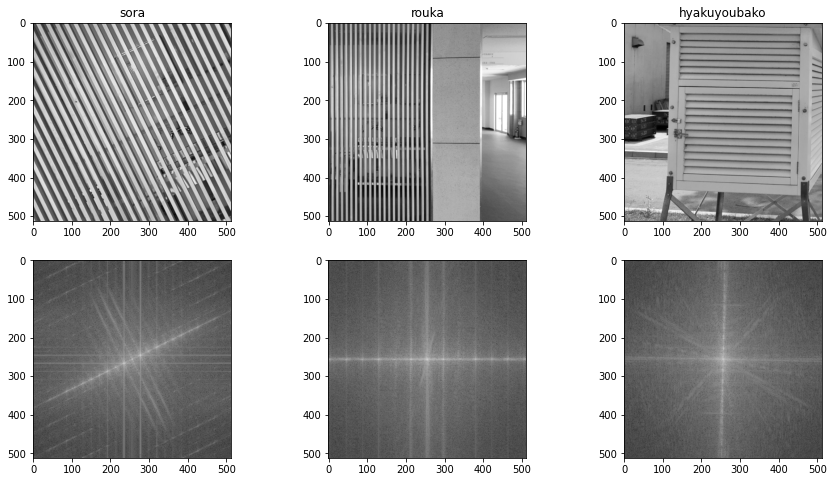

In [ ]:
def calc_spectrum(img):
  img_fft = np.fft.fft2(img)
  fshift = np.fft.fftshift(img_fft)
  return 20*np.log(np.abs(fshift))

lena = cv2.imread('/content/drive/MyDrive/naname.jpg',0)
boat = cv2.imread('/content/drive/MyDrive/rouka.jpg',0)
ruler = cv2.imread('/content/drive/MyDrive/hyakuyoubako.jpg',0)


fig, [[ax_lena, ax_boat, ax_ruler], [ax_lena_fft, ax_boat_fft, ax_ruler_fft]] = plt.subplots(2, 3, figsize=(15, 8))
plt.gray()

ax_lena.imshow(lena)
ax_lena.set_title("sora")
ax_lena_fft.imshow(calc_spectrum(lena))

ax_boat.imshow(boat)
ax_boat.set_title("rouka")
ax_boat_fft.imshow(calc_spectrum(boat))


ax_ruler.imshow(ruler)
ax_ruler.set_title("hyakuyoubako")
ax_ruler_fft.imshow(calc_spectrum(ruler))

plt.show()

縞模様の画像をFFTすると、その縞と直行する方向に

強いスペクトルの線がある

画素値を考えると、白は255で黒は0

つまり、縞模様を直角の方向で見ると、

波になっていることがわかる

ローパスフィルタをかける

周波数（半径）を変えて、アニメーションを作ってみる

低周波の領域だけで再構成しても、

画像の（見た目の）特徴をある程度残しているように見える

→高周波の情報を減らすことで、見た目をそのままに

画像のデータ量を減らすことができる

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


<Figure size 432x288 with 0 Axes>

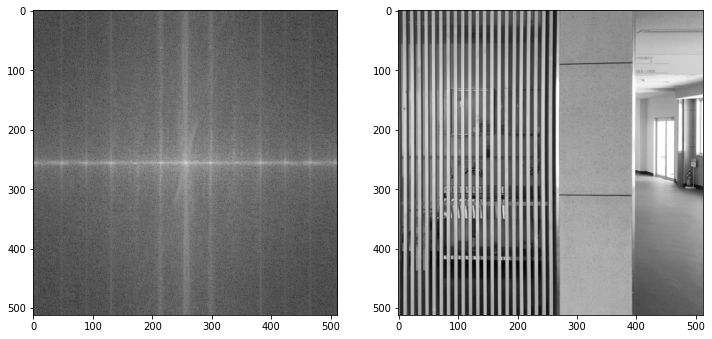

In [ ]:
def mask_to_fshift(fshift, R):
  size = fshift.shape
  mask = np.zeros(size)
  length = size[0]
  centery = size[0]/2
  for x in range(0,length):
    for y in range(0,length):
      if (x- centery)**2 +(y- centery)**2 <R**2:
        mask[x,y]=1
  return fshift*mask


plt.gray()
ims = []
fig, [ax_fft, ax_image] = plt.subplots(1, 2, figsize=(12, 8))
for i in range(50):
  fshift_mask = mask_to_fshift(fshift.copy(), 1.15**i)
  magnitude_spectrum = 20*np.log(np.abs(fshift_mask))
  im_fft = ax_fft.imshow(magnitude_spectrum)

  fshift_mask= np.fft.fftshift(fshift_mask) 
  ifimage = np.fft.ifft2(fshift_mask) 
  ifimage = ifimage.real
  im_image = ax_image.imshow(ifimage)    

  ims.append([im_fft, im_image])  

ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                repeat_delay=1000)
ani.save('anim.gif', writer = "pillow", fps=20)
HTML(ani.to_html5_video())


## 2. 画像の空間領域フィルタと周波数（必須課題）

2年生の実験で画像のフィルタリングを学習した。

画像に対して、例えば5x5のフィルタを畳み込む

画像の平滑化フィルタとして、

移動平均フィルタ`kernel_movingaverage`と、

ガウシアンフィルタ`kernel_gaussian`を用意した。


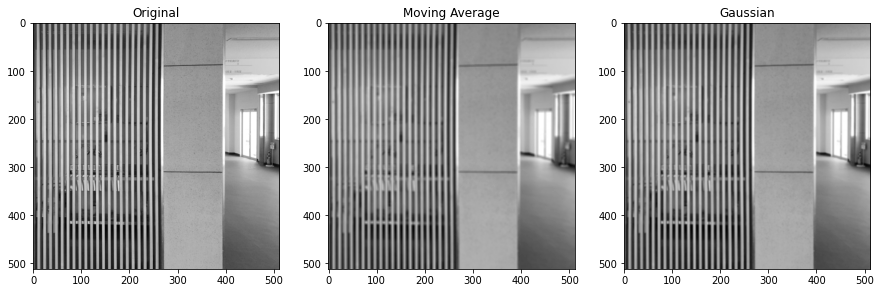

In [ ]:
kernel_original = np.array([[0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0],
                            [0, 0, 1, 0, 0],
                            [0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0]])

kernel_movingaverage = np.array([[1, 1, 1, 1, 1],
                                 [1, 1, 1, 1, 1],
                                 [1, 1, 1, 1, 1],
                                 [1, 1, 1, 1, 1],
                                 [1, 1, 1, 1, 1]]) / 25

kernel_gaussian = np.array([[1,  4,  6,  4, 1],
                            [4, 16, 24, 16, 4],
                            [6, 24, 36, 24, 6],
                            [4, 16, 24, 16, 4],
                            [1,  4,  6,  4, 1]]) / 256

fig, [ax_img_original, ax_img_movingaverage, ax_img_gaussian] = plt.subplots(1, 3, figsize=(15, 8))

img = cv2.imread('/content/drive/MyDrive/rouka.jpg',0)

img_original = cv2.filter2D(img, -1, kernel_original)
ax_img_original.imshow(img_original)
ax_img_original.set_title("Original")

img_movingaverage = cv2.filter2D(img, -1, kernel_movingaverage)
ax_img_movingaverage.imshow(img_movingaverage)
ax_img_movingaverage.set_title("Moving Average")

img_gaussian = cv2.filter2D(img, -1, kernel_gaussian)
ax_img_gaussian.imshow(img_gaussian)
ax_img_gaussian.set_title("Gaussian")

plt.show()

#### 移動平均フィルタ

フィルタを3x3, 5x5, 7x7…と大きくしてアニメーションを作成する

フィルタが大きいほど平滑化の効果は強くなる

スペクトルはだんだん中心に集まっている

つまり、周波数領域で見ると、ローパスフィルタの役割をしている



In [ ]:
def calc_spectrum(img):
  img_fft = np.fft.fft2(img)
  fshift = np.fft.fftshift(img_fft)
  return 20*np.log(np.abs(fshift))

<Figure size 432x288 with 0 Axes>

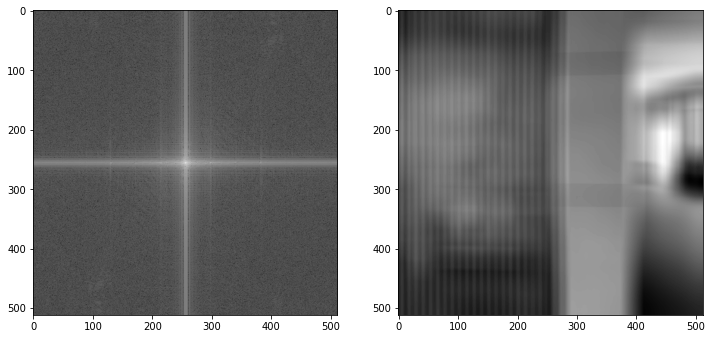

In [ ]:
plt.gray()
ims = []
fig, [ax_fft, ax_image] = plt.subplots(1, 2, figsize=(12, 8))
for i in range(1, 40, 2):
  img_movingaverage = cv2.blur(img, (i, i))
  im_image = ax_image.imshow(img_movingaverage)   

  im_fft = ax_fft.imshow(calc_spectrum(img_movingaverage))

  ims.append([im_image, im_fft])  

ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                repeat_delay=1000)
ani.save('anim.gif', writer = "pillow", fps=20)
HTML(ani.to_html5_video())

#### ガウシアンフィルタ

ガウシアンフィルタでは、周りの画素を一律に平均するのではなく、

注目している画素の近くに重み付けしてある

$$ f(x, y)=\frac{1}{2\pi\sigma^2} \exp({-\frac{x^2+y^2}{2\sigma^2}})$$

フィルタを3x3, 5x5, 7x7…と大きくし、それに合わせて標準偏差 $ \sigma $ を大きくする

標準偏差が大きいほど平滑化の効果は強くなる

周波数領域で見ると、移動平均フィルタと同じく

ローパスフィルタの役割をしている

実は微妙に効果が違う

FFT、IFFTを使ってローパスフィルタを作ると

完璧に周波数をフィルタリングできるが、
計算量がかなり大きい

計算量の少ない空間領域のフィルタだけで、
ローパスフィルタの代用になる

<Figure size 432x288 with 0 Axes>

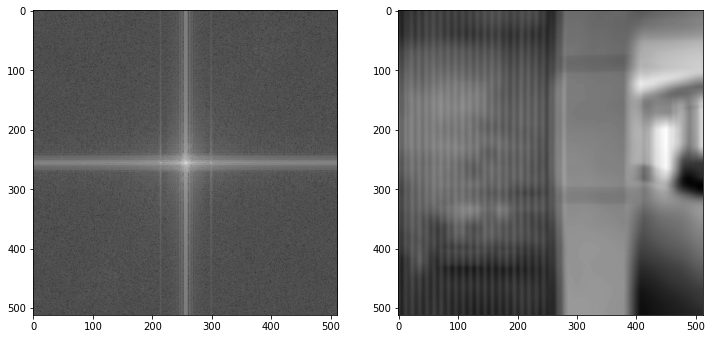

In [ ]:
plt.gray()
ims = []
fig, [ax_fft, ax_image] = plt.subplots(1, 2, figsize=(12, 8))
for i in range(1, 30, 2):
  img_gaussian = cv2.GaussianBlur(img, (i, i), i/2)
  im_image = ax_image.imshow(img_gaussian)   

  im_fft = ax_fft.imshow(calc_spectrum(img_gaussian))

  ims.append([im_image, im_fft])  

ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                repeat_delay=1000)
ani.save('anim.gif', writer = "pillow", fps=20)
HTML(ani.to_html5_video())

## 3. 音声の周波数領域フィルタ（必須課題）

高周波ノイズが加えられた音声を用意する

ノイズの入った音声のスペクトログラムを見ると、

高周波に強いエネルギーがある

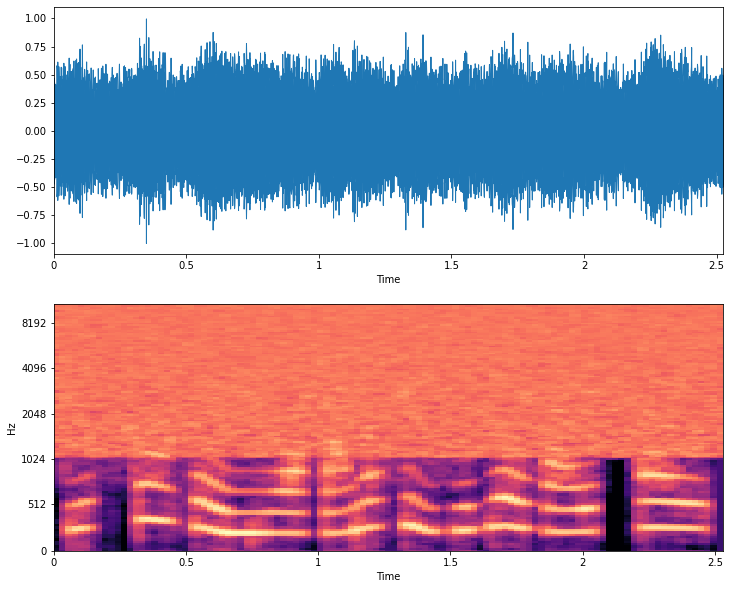

In [ ]:
y_voice, sr_voice = librosa.load('/content/drive/MyDrive/voice_with_noise_100.wav')
show_wave_spectrogram_audio(y_voice, sr_voice)

FFTを行い、ある周波数以上をカットすると、ノイズがなくなった

(1025, 109)


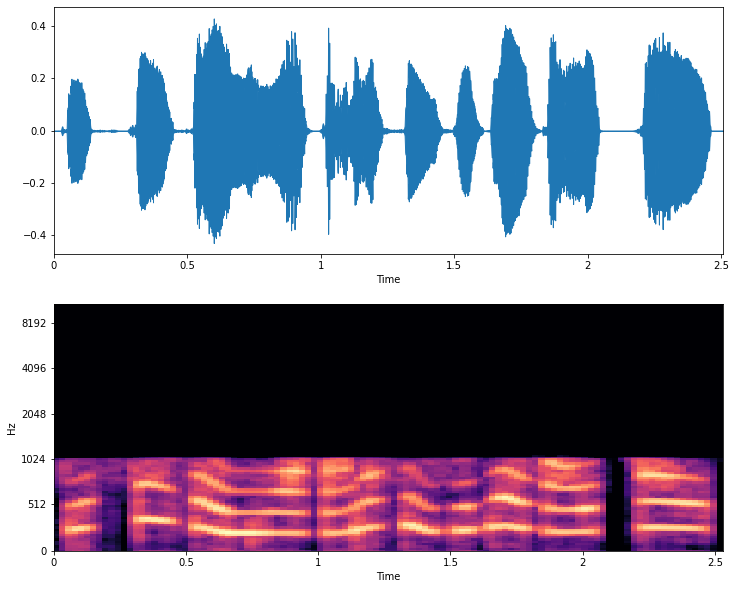

In [ ]:
n_fft = 2048
D = librosa.stft(y_voice, n_fft=n_fft)
print(D.shape)
D[0:80] = 0
y_voice_lowpass = librosa.istft(D)
show_wave_spectrogram_audio(y_voice_lowpass, sr_voice)

次は音楽を使ってみる

まずは読み込み

(661500,)
22050


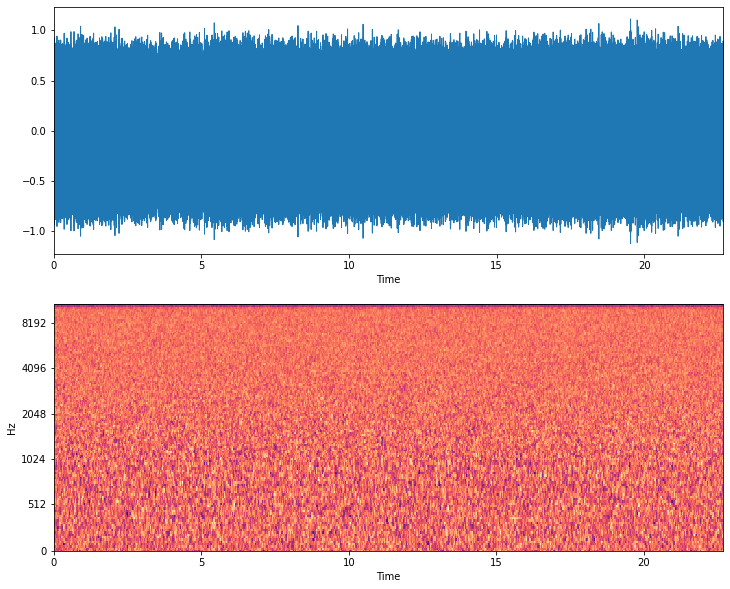

In [ ]:
def show_spectrogram(y, sr):
  S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
  log_S = librosa.power_to_db(S, ref=np.max)
  plt.figure(figsize=(10, 4))
  librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
  plt.title('mel power spectrogram')
  plt.colorbar(format='%+02.0f dB')
  plt.show()

def show_wave_spectrogram_audio(y, sr):
  fig, [ax_wave, ax_spectrogram] = plt.subplots(2, 1, figsize=(12, 10))
  S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
  log_S = librosa.power_to_db(S, ref=np.max)
  librosa.display.waveplot(y, sr=sr, x_axis='time', ax=ax_wave)
  spectrogram = librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel', ax=ax_spectrogram)
  plt.show()
  display(Audio(y, rate=sr))

y_tropical, sr_tropical = librosa.load('/content/drive/MyDrive/whitenoise.wav', mono=True)
print(y_tropical.shape)
print(sr_tropical)
y_tropical = y_tropical[:500000]
show_wave_spectrogram_audio(y_tropical, sr_tropical)

ローパスフィルターやハイパスフィルターを試す

聴覚上の変化はどうなる？スペクトログラム上では？

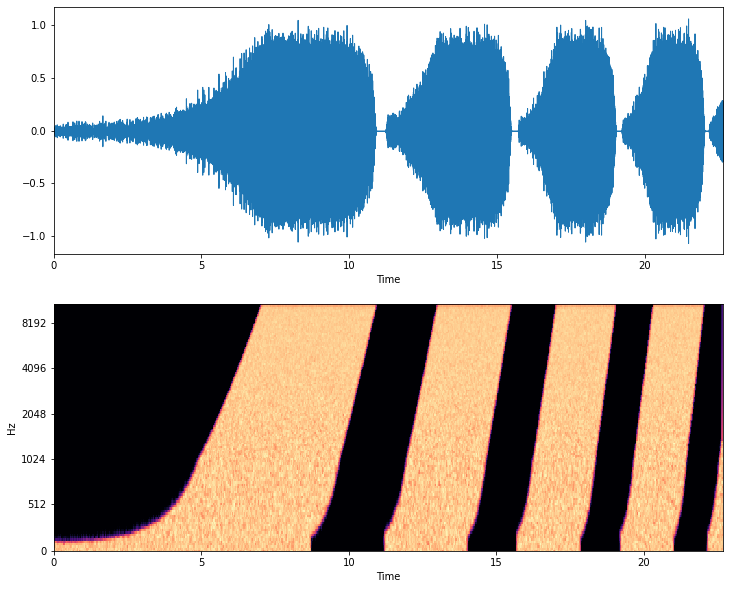

In [ ]:
n_fft = 2048
D = librosa.stft(y_tropical, n_fft=n_fft)
flag = 0
freq_pass = 10
for i in range(len(D[0])):
  if flag == 0:
    D[int(freq_pass):, i] = 0
    freq_pass *= 1.00 + (i * 0.0001)
    if freq_pass > 10000:
      flag = 1
      freq_pass = 20
  elif flag == 1:
    D[:int(freq_pass), i] = 0
    freq_pass *= 1.00 + (i * 0.0001)
    if freq_pass > 2000:
      flag = 0
      freq_pass = 20

y_tropical_lowpass = librosa.istft(D)
show_wave_spectrogram_audio(y_tropical_lowpass, sr_tropical)

## 4. 音声の時間領域フィルタと周波数（発展課題）

$ n $ 点の平均をとるような移動平均フィルタを設計し、

音楽に畳み込む

これは方形波を畳み込んでいる

これを2次元にすると画像の平滑化フィルタになる

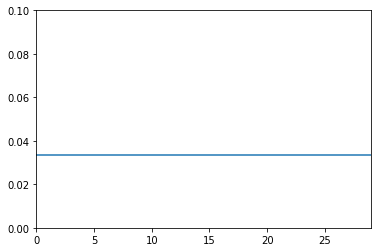

In [ ]:
n = 30
filter_movingaverage = np.ones(n)/n
plt.plot(filter_movingaverage)
plt.xlim(0, 29)
plt.ylim(0, 0.1)
plt.show()

ホワイトノイズにフィルタを適用すると、

高周波のエネルギーが弱くなった

しかし、謎の線が何本も出た

低周波を残したいのに、謎の線のせいで低周波の一部が失われている

ローパスフィルタとしてはあまり優秀ではない

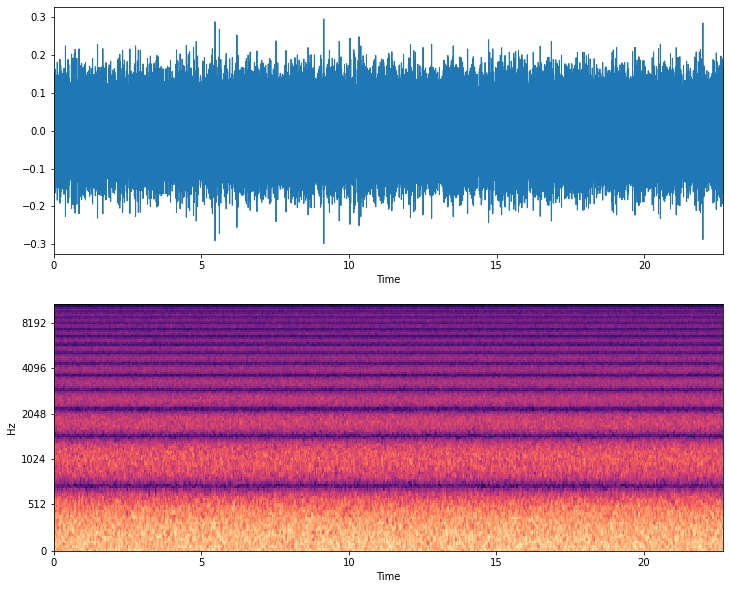

In [ ]:
y_tropical_filtered = np.convolve(y_tropical, filter_movingaverage)
show_wave_spectrogram_audio(y_tropical_filtered, sr_tropical)

今度は
$ A\exp{-t/\tau} $
の形で減衰する

指数平滑フィルタを設計し、畳み込む

移動平均フィルタと違いはあるか？

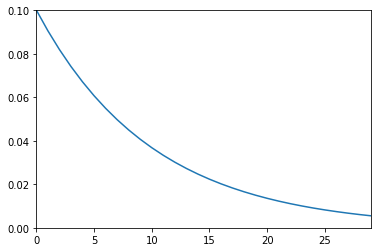

In [ ]:
n = 30
filter_exp = np.exp(-np.arange(n)/(n/3))
filter_exp /= np.sum(filter_exp)
plt.plot(filter_exp)
plt.xlim(0, 29)
plt.ylim(0, 0.1)
plt.show()

こちらも高周波ほどエネルギーが弱くなり、

画像へのフィルタで言うガウシアンフィルタのような役割をしている

移動平均と異なり、謎の線は出てこず、

高周波にかけて徐々にエネルギーが弱くなっている

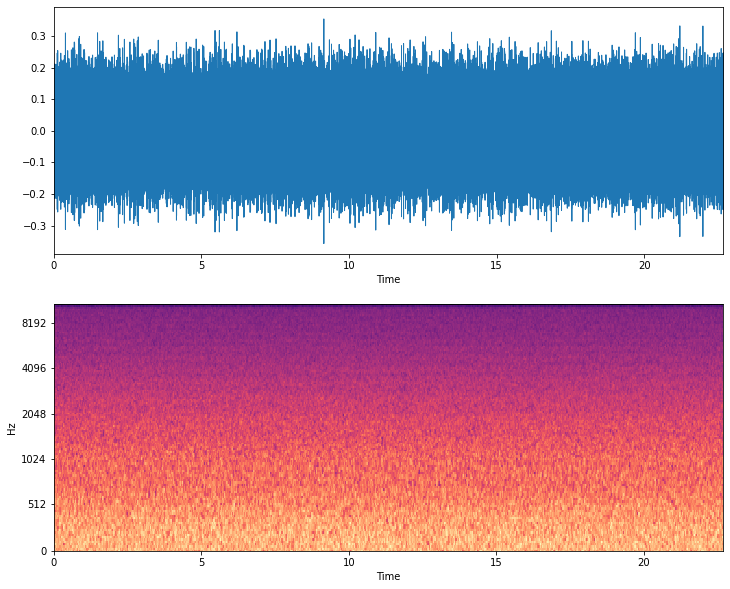

In [ ]:
y_tropical_filtered = np.convolve(y_tropical, filter_exp)
show_wave_spectrogram_audio(y_tropical_filtered, sr_tropical)

## 5. サンプリングと波形の復元（発展課題）

まず、正弦波を荒くサンプリングする

1周期あたり5点

No handles with labels found to put in legend.


[ 1.          0.30901699 -0.80901699 -0.80901699  0.30901699  1.
  0.30901699 -0.80901699 -0.80901699  0.30901699  1.          0.30901699
 -0.80901699 -0.80901699  0.30901699  1.        ]


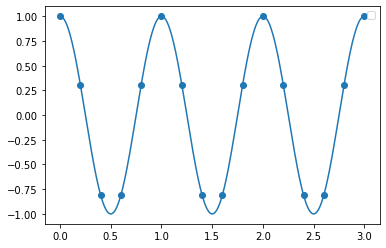

In [ ]:
# 周期あたり何点サンプリングするか。ここが2未満だと正しくサンプリングできない
sampling_per_period = 5

sampling_period = int(100 / sampling_per_period)
x = np.linspace(0, 3, 301)
y = np.cos(x*np.pi*2)
x_sampling = x[::sampling_period]
y_sampling = y[::sampling_period]
print(y_sampling)
plt.plot(x, y)
plt.scatter(x_sampling, y_sampling)
plt.legend()
plt.show()

サンプリングした点だけ出すと

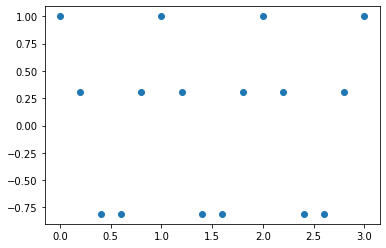

In [ ]:
plt.scatter(x_sampling, y_sampling)

それぞれにsinc関数を畳み込んで合計すると、

おおよそ元の波形に戻った

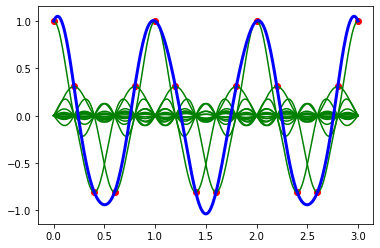

In [ ]:
sincs = []

for y_temp, x_temp in zip(y_sampling, x_sampling):
  sincs.append(y_temp * np.sinc(100 / sampling_period * (x_temp - x)))

for sinc in sincs:
  plt.plot(x, sinc, color = "green")

sum_sinc = sum(sincs)
plt.plot(x, sum_sinc, color="blue", lw=3)

plt.scatter(x_sampling, y_sampling, color="red")

次に、1周期あたり1.8点をサンプリングしてみる

1周期あたり2点未満になると、正しく復元できない

No handles with labels found to put in legend.


[ 1.00000000e+00 -9.51056516e-01  8.09016994e-01 -5.87785252e-01
  3.09016994e-01 -2.44991258e-15]


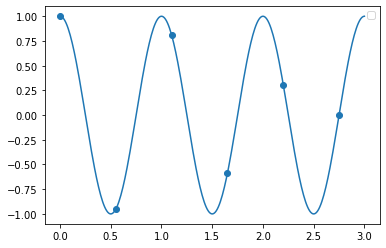

In [ ]:
sampling_per_period = 1.8
sampling_period = int(100 / sampling_per_period)
x = np.linspace(0, 3, 301)
y = np.cos(x*np.pi*2)
x_sampling = x[::sampling_period]
y_sampling = y[::sampling_period]
print(y_sampling)
plt.plot(x, y)
plt.scatter(x_sampling, y_sampling)
plt.legend()
plt.show()

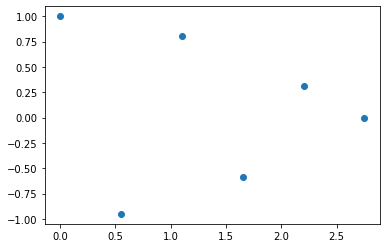

In [ ]:
plt.scatter(x_sampling, y_sampling)

復元しようとしても、うまくいかない

これは、**標本化定理**のため

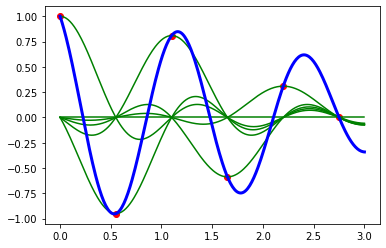

In [ ]:
sincs = []

for y_temp, x_temp in zip(y_sampling, x_sampling):
  sincs.append(y_temp * np.sinc(100 / sampling_period * (x_temp - x)))

for sinc in sincs:
  plt.plot(x, sinc, color = "green")

sum_sinc = sum(sincs)
plt.plot(x, sum_sinc, color="blue", lw=3)

plt.scatter(x_sampling, y_sampling, color="red")